C:\Users\Dhananjay R\AppData\Local\Temp\ipykernel_1896\1701133878.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions.append(forecast[0])
C:\Users\Dhananjay R\AppData\Local\Temp\ipykernel_1896\1701133878.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions.append(forecast[0])
C:\Users\Dhananjay R\AppData\Local\Temp\ipykernel_1896\1701133878.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions.app

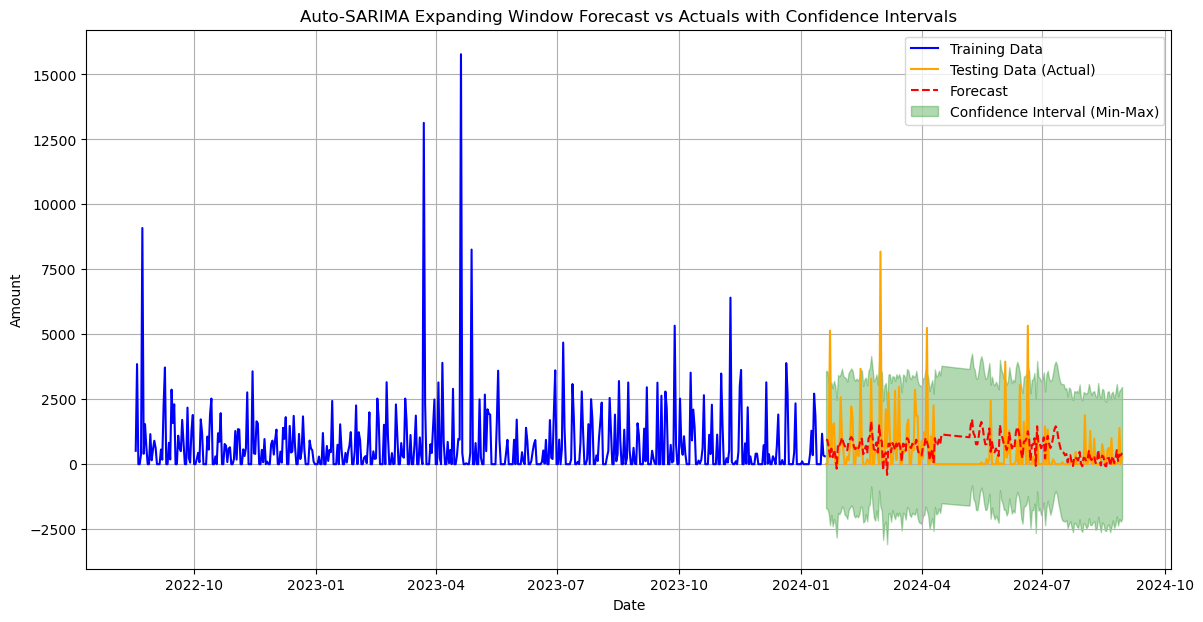

Mean Absolute Error (MAE): 795.22
Mean Squared Error (MSE): 1285945.14
Root Mean Squared Error (RMSE): 1134.00
Total Forecasted Amount: 155033.36
Forecast results saved to 'Revenue_forecast_AutoSARIMA_ExpandingWindow.csv'.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to load and prepare the dataset
def load_and_prepare_data(filepath, time_column, target_column):
    """
    Load the dataset, ensure the time column is in datetime format,
    and prepare it for time series forecasting.
    """
    data = pd.read_csv(filepath)
    data[time_column] = pd.to_datetime(data[time_column])
    data.set_index(time_column, inplace=True)
    data.sort_index(inplace=True)
    return data[target_column]

# Function to perform Auto-SARIMA expanding window forecasting
def auto_sarima_expanding_window(series, initial_train_ratio=0.7, seasonal=False, **sarima_kwargs):
    """
    Perform Auto-SARIMA expanding window forecasting.
    """
    train_size = int(len(series) * initial_train_ratio)
    test_size = len(series) - train_size

    actuals, predictions, lower_bounds, upper_bounds = [], [], [], []

    for i in range(test_size):
        # Split data into training and test sets for the current iteration
        train = series.iloc[:train_size + i]
        test = series.iloc[train_size + i:train_size + i + 1]

        # Fit the Auto-SARIMA model
        model = auto_arima(
            train,
            seasonal=seasonal,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            trace=False,
            **sarima_kwargs
        )

        # Forecast the next step
        forecast, conf_int = model.predict(n_periods=1, return_conf_int=True)

        # Append results
        actuals.append(test.values[0])
        predictions.append(forecast[0])
        lower_bounds.append(conf_int[0, 0])
        upper_bounds.append(conf_int[0, 1])

    # Create a DataFrame for results
    comparison_df = pd.DataFrame({
        'Actual': actuals,
        'Predicted': predictions,
        'Lower_CI': lower_bounds,
        'Upper_CI': upper_bounds
    }, index=series.index[train_size:])

    return comparison_df

# Function to plot forecast results
def plot_forecast(series, train_size, comparison_df, title, ylabel):
    """
    Plot forecast results with confidence intervals.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(series.index[:train_size], series[:train_size], label="Training Data", color="blue")
    plt.plot(series.index[train_size:], comparison_df["Actual"], label="Testing Data (Actual)", color="orange")
    plt.plot(series.index[train_size:], comparison_df["Predicted"], label="Forecast", color="red", linestyle="--")
    plt.fill_between(series.index[train_size:], comparison_df["Lower_CI"], comparison_df["Upper_CI"],
                     color="green", alpha=0.3, label="Confidence Interval (Min-Max)")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

# Main pipeline function
def main(filepath, time_column, target_column, initial_train_ratio=0.7, seasonal=False, **sarima_kwargs):
    """
    Main pipeline to perform Auto-SARIMA expanding window forecasting.
    """
    # Load and prepare data
    series = load_and_prepare_data(filepath, time_column, target_column)

    # Perform Auto-SARIMA expanding window forecast
    comparison_df = auto_sarima_expanding_window(
        series,
        initial_train_ratio=initial_train_ratio,
        seasonal=seasonal,
        **sarima_kwargs
    )

    # Plot results
    train_size = int(len(series) * initial_train_ratio)
    plot_forecast(
        series,
        train_size,
        comparison_df,
        title="Auto-SARIMA Expanding Window Forecast vs Actuals with Confidence Intervals",
        ylabel="Amount"
    )

    # Calculate metrics
    mae = mean_absolute_error(comparison_df["Actual"], comparison_df["Predicted"])
    mse = mean_squared_error(comparison_df["Actual"], comparison_df["Predicted"])
    rmse = np.sqrt(mse)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Total forecasted amount
    total_forecast = sum(comparison_df["Predicted"])
    print(f"Total Forecasted Amount: {total_forecast:.2f}")

    # Save forecasted results to a CSV
    output_file = "Revenue_forecast_AutoSARIMA_ExpandingWindow.csv"
    comparison_df.to_csv(output_file, index=False)
    print(f"Forecast results saved to '{output_file}'.")

# Run the pipeline dynamically
if __name__ == "__main__":
    FILEPATH = r"C:\upi_data\transactions_single_account.csv"
    TIME_COLUMN = "transaction_date"
    TARGET_COLUMN = "total_revenue"
    main(
        filepath=FILEPATH,
        time_column=TIME_COLUMN,
        target_column=TARGET_COLUMN,
        initial_train_ratio=0.7,
        seasonal=False  # Adjust to True if seasonality is present
    )
